In [9]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy import stats
import early_warning_detection_functions
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy import signal

import seaborn as sns


# Read the data

In [10]:
df_aih = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_aih_imed_for_regre.parquet')

df = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_otc_phc_imed.parquet')



In [11]:
df_aih.aih_4 =  df_aih.aih_4.fillna(0).astype(int)

In [12]:
dta1 = df[['sigla_uf', 'co_uf', 'nm_uf', 'co_imed', 'Nome_imed', 'year_week',
       'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end', 'atend_ivas',
       'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4', 
       'phc_4_lag_1', 'phc_4_lag_2', 'phc_4_lag_3', 'otc_4_lag_1',
       'otc_4_lag_2', 'otc_4_lag_3']]

In [13]:
df_aih.columns

Index(['co_imed', 'year_week', 'warning_aih', 'n',
       'warning_aih_without_isolated', 'warning_aih_corect_with_consec',
       'warning_final_aih', 'aih_4', 'aih_4_lag_1', 'aih_4_lag_2',
       'aih_4_lag_3', 'time_trend', 'coef_negbi_aih_4', 'std_err_negbi_aih_4',
       'z_negbi_aih_4', 'p_values_negbi_aih_4', 'IC_low_negbi_aih_4',
       'IC_high_negbi_aih_4', 'trend_line_negbi_aih_4', 'dtrend_aih_negbi',
       'aih_4_sea', 'p_value_aih_negbi_friedman',
       'test_stat_aih_negbi_friedman', 'seas_decom_aih'],
      dtype='object')

In [14]:
dta2 = df_aih[['co_imed', 'year_week', 'n',
       'aih_4', 'aih_4_lag_1', 'aih_4_lag_2',
       'aih_4_lag_3']]

In [15]:
dta = dta1.merge(dta2, on = ['co_imed', 'year_week'], how = 'left')

In [26]:
def lagged_correlation(series1, series2, max_lag):
    """
    Compute cross-correlation for different lags up to max_lag.
    """
    lags = np.arange(-max_lag, max_lag + 1)
    correlations = [np.corrcoef(series1[max_lag:], np.roll(series2, lag)[max_lag:])[0, 1] for lag in lags]

    return lags, correlations


In [27]:
def compute_max_lagged_correlation(data, series1_name, series2_name, max_lag=3):
    """Computes the max lagged correlation for two time series in a DataFrame.
       A high positive correlation at a certain lag means that series2 follows 
       series1 after that many time steps.
    """
    series1 = data[series1_name][3:].to_numpy()
    series2 = data[series2_name][3:].to_numpy()
    
    lags, correlations = lagged_correlation(series1, series2, max_lag=max_lag)
    
    # Find the maximum correlation value and its corresponding lag
    max_corr_idx = correlations.index(max(correlations))
    return lags[max_corr_idx], correlations[max_corr_idx]

In [28]:
# List of regions
regions = dta.co_imed.unique()

# List to store results
results = []

# Loop through each region
for region in regions:
    data = dta[dta.co_imed == region][['co_imed', 'atend_ivas_4', 'num_otc_ivas_4', 'aih_4']]
    data.aih_4 = np.nan_to_num(data.aih_4.to_numpy(), nan=0)
    
    # Compute correlations for different pairs of series
    lag_aps_otc, corr_aps_otc = compute_max_lagged_correlation(data, 'atend_ivas_4', 'num_otc_ivas_4')
    lag_aih_aps, corr_aih_aps = compute_max_lagged_correlation(data, 'aih_4', 'atend_ivas_4')
    lag_aih_otc, corr_aih_otc = compute_max_lagged_correlation(data, 'aih_4', 'num_otc_ivas_4')
    
    # Append results
    results.append({
        'co_imed': region,
        'Lag_APS_OTC': lag_aps_otc,
        'Correlation_APS_OTC': corr_aps_otc,
        'Lag_AIH_APS': lag_aih_aps,
        'Correlation_AIH_APS': corr_aih_aps,
        'Lag_AIH_OTC': lag_aih_otc,
        'Correlation_AIH_OTC': corr_aih_otc
    })

# Convert results to DataFrame
df_lagged_corr = pd.DataFrame(results)




In [29]:
# Function to classify correlation strength
def classify_correlation(value):
    if abs(value) < 0.2:
        return "Very Weak"
    elif abs(value) < 0.4:
        return "Weak"
    elif abs(value) < 0.6:
        return "Moderate"
    elif abs(value) < 0.8:
        return "Strong"
    else:
        return "Very Strong"

In [30]:
# Apply the classification function to each correlation column
df_lagged_corr['Correlation_aps_otc_Class'] = df_lagged_corr['Correlation_APS_OTC'].apply(classify_correlation)
df_lagged_corr['Correlation_aih_aps_Class'] = df_lagged_corr['Correlation_AIH_APS'].apply(classify_correlation)
df_lagged_corr['Correlation_aih_otc_Class'] = df_lagged_corr['Correlation_AIH_OTC'].apply(classify_correlation)




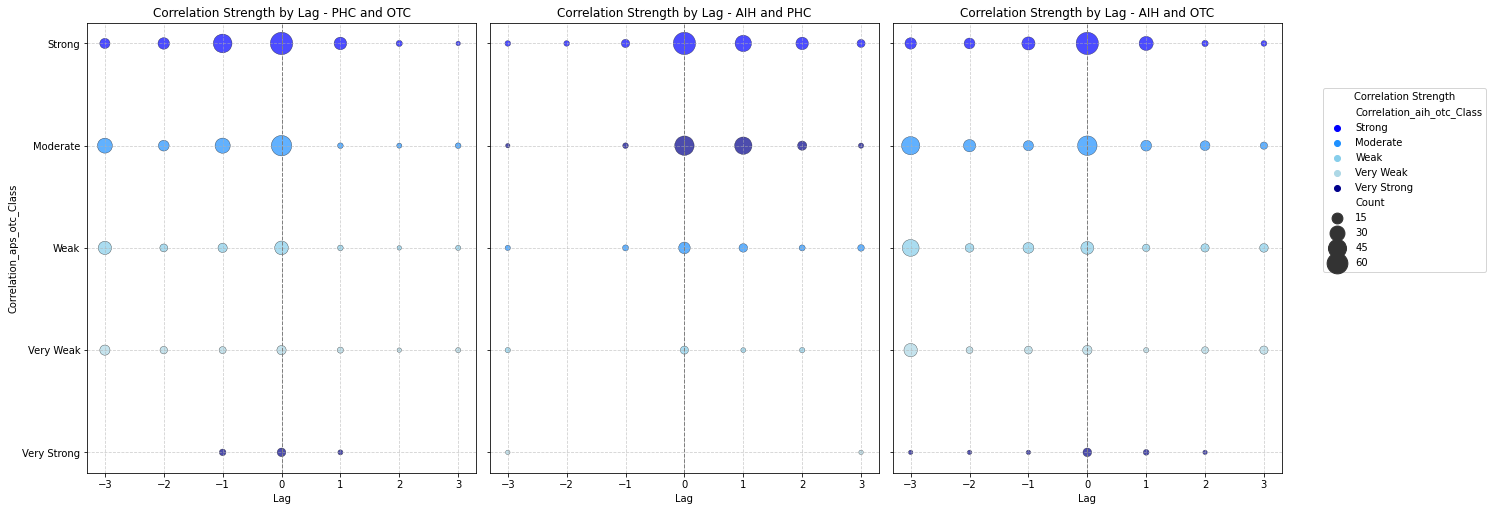

In [32]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Define common color palette
palette = {
    "Very Weak": "lightblue",
    "Weak": "skyblue",
    "Moderate": "dodgerblue",
    "Strong": "blue",
    "Very Strong": "darkblue"
}

# List of correlation variables
correlation_vars = [
    ("Correlation_aps_otc_Class", "Lag_APS_OTC", "PHC and OTC", axes[0]),
    ("Correlation_aih_aps_Class", "Lag_AIH_APS", "AIH and PHC", axes[1]),
    ("Correlation_aih_otc_Class", "Lag_AIH_OTC", "AIH and OTC", axes[2])
]

# Plot each correlation as a bubble plot
for corr_col, lag_col, title, ax in correlation_vars:
    df = df_lagged_corr[[corr_col, lag_col]].value_counts().reset_index()
    df = df.rename(columns={0: 'Count'})

    scatter = sns.scatterplot(data=df, x=lag_col, y=corr_col, size='Count', sizes=(20, 500),
                              hue=corr_col, palette=palette, edgecolor='black', alpha=0.7, ax=ax)

    ax.axvline(0, color='gray', linestyle='--', linewidth=1)  # Vertical line at lag 0
    ax.set_xlabel('Lag')
    ax.set_title(f'Correlation Strength by Lag - {title}')
    ax.grid(True, linestyle='--', alpha=0.6)

    # Remove legend from each subplot
    ax.get_legend().remove()

# Create a single legend outside the subplots
handles, labels = scatter.get_legend_handles_labels()
fig.legend(handles, labels, title="Correlation Strength", bbox_to_anchor=(1.02, 1), loc='upper left')

# Set common y-label
#fig.text(0.08, 0.5, 'Correlation Strength', va='center', rotation='vertical', fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1.2])

# Show plot
plt.show()


In [33]:
df_lagged_corr = df_lagged_corr.assign(ones = 1)

### Counts of reagions with Moderate to very strong lagged correlations between APS and OTC series

In [42]:
df_lagged_corr.Correlation_aps_otc_Class.value_counts()*100/510

Strong         39.411765
Moderate       31.960784
Weak           16.078431
Very Weak       9.215686
Very Strong     3.333333
Name: Correlation_aps_otc_Class, dtype: float64

In [44]:
# Number of regions with Moderate tp Very strong correlation between APS and OTC timeseries
round(100 - (9.215686 + 16.078431),1)

74.7

In [48]:
dta_h = df_lagged_corr[(df_lagged_corr.Correlation_aps_otc_Class != 'Very Weak') & (df_lagged_corr.Correlation_aps_otc_Class != 'Weak')]

In [49]:
dta_h.Correlation_aps_otc_Class.value_counts()*100/510

Strong         39.411765
Moderate       31.960784
Very Strong     3.333333
Name: Correlation_aps_otc_Class, dtype: float64

In [50]:
a = dta_h.groupby(['Lag_APS_OTC'])['ones'].sum().reset_index()
a = a.assign(per = round(a.ones*100/510,1))
a

,Lag_APS_OTC,ones,per
0,-3,50,9.8
1,-2,37,7.3
2,-1,97,19.0
3,0,158,31.0
4,1,29,5.7
5,2,6,1.2
6,3,4,0.8


In [51]:
a.per[0:3].sum()

36.1

In [52]:
a.per[4:].sum()

7.7

In [53]:
510 - a.ones.sum()

129

In [54]:
round((510 - a.ones.sum())*100/510,1)

25.3

In [55]:
round(a.ones.sum()*100/510,1)

74.7

### Counts of reagions with Moderate to very strong lagged correlations between AIH and APS series

In [93]:
df_lagged_corr.Correlation_aih_aps_Class.value_counts()*100/510

Strong         47.843137
Very Strong    35.490196
Moderate       12.352941
Weak            3.921569
Very Weak       0.392157
Name: Correlation_aih_aps_Class, dtype: float64

In [94]:
round(100 - (0.392157 + 3.921569),1)

95.7

In [95]:
dta_h2 = df_lagged_corr[(df_lagged_corr.Correlation_aih_aps_Class != 'Very Weak') & (df_lagged_corr.Correlation_aih_aps_Class != 'Weak')]



In [96]:
b = dta_h2.groupby(['Lag_AIH_APS'])['ones'].sum().reset_index()
b = b.assign(per = round(b.ones*100/510,1))
b

,Lag_AIH_APS,ones,per
0,-3,8,1.6
1,-2,4,0.8
2,-1,22,4.3
3,0,232,45.5
4,1,144,28.2
5,2,56,11.0
6,3,22,4.3


In [97]:
b.per[0:3].sum()

6.7

In [98]:
b.per[4:].sum()

43.5

In [99]:
510 - b.ones.sum()

22

In [100]:
round((510 - b.ones.sum())*100/510,1)

4.3

In [101]:
round(b.ones.sum()*100/510,1)

95.7

### Counts of reagions with Moderate to very strong lagged correlations between AIH and OTC series

In [82]:
df_lagged_corr.head()

,co_imed,Lag_APS_OTC,Correlation_APS_OTC,Lag_AIH_APS,Correlation_AIH_APS,Lag_AIH_OTC,Correlation_AIH_OTC,Correlation_aps_otc_Class,Correlation_aih_aps_Class,Correlation_aih_otc_Class,ones
0,120001,1,0.636540,2,0.635220,-3,0.478631,Strong,Strong,Moderate,1
1,120002,0,0.637133,0,0.645948,-2,0.536027,Strong,Strong,Moderate,1
2,120003,0,0.464702,0,0.406358,-1,0.418410,Moderate,Moderate,Moderate,1
3,120004,1,0.810444,2,0.670127,1,0.656134,Very Strong,Strong,Strong,1
4,120005,-1,0.689188,1,0.744383,0,0.660064,Strong,Strong,Strong,1


In [102]:
dta_h3 = df_lagged_corr[(df_lagged_corr.Correlation_aih_otc_Class != 'Very Weak') & (df_lagged_corr.Correlation_aih_otc_Class != 'Weak')]



In [103]:
c = dta_h3.groupby(['Lag_AIH_OTC'])['ones'].sum().reset_index()
c = c.assign(per = round(c.ones*100/510,1))
c

,Lag_AIH_OTC,ones,per
0,-3,64,12.5
1,-2,36,7.1
2,-1,37,7.3
3,0,132,25.9
4,1,45,8.8
5,2,17,3.3
6,3,9,1.8


In [104]:
round(c.per[0:3].sum(),1)

26.9

In [105]:
round(c.per[4:].sum(),1)

13.9

In [106]:
26.9 + 13.9

40.8

In [107]:
510 - c.ones.sum()

170

In [108]:
round((510 - c.ones.sum())*100/510,1)

33.3

In [109]:
round(c.ones.sum()*100/510,1)

66.7

In [241]:
# Load shapefile of immediate regions (you need to download this from IBGE)
shapefile_path = '/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Data/RG2017_rgi_20180911/RG2017_rgi.shp'  # update with actual file
gdf = gpd.read_file(shapefile_path)

# Make sure 'co_imed' in both files is string for easier merge
gdf['co_imed'] = gdf['rgi']  # Adjust if the column is different in your file
gdf['co_imed'] = gdf['co_imed'].astype(str)



In [242]:
df_lagged_corr.co_imed = df_lagged_corr.co_imed.astype(str)

In [243]:
gdf = gdf.merge(df_lagged_corr, on = 'co_imed', how = 'left')

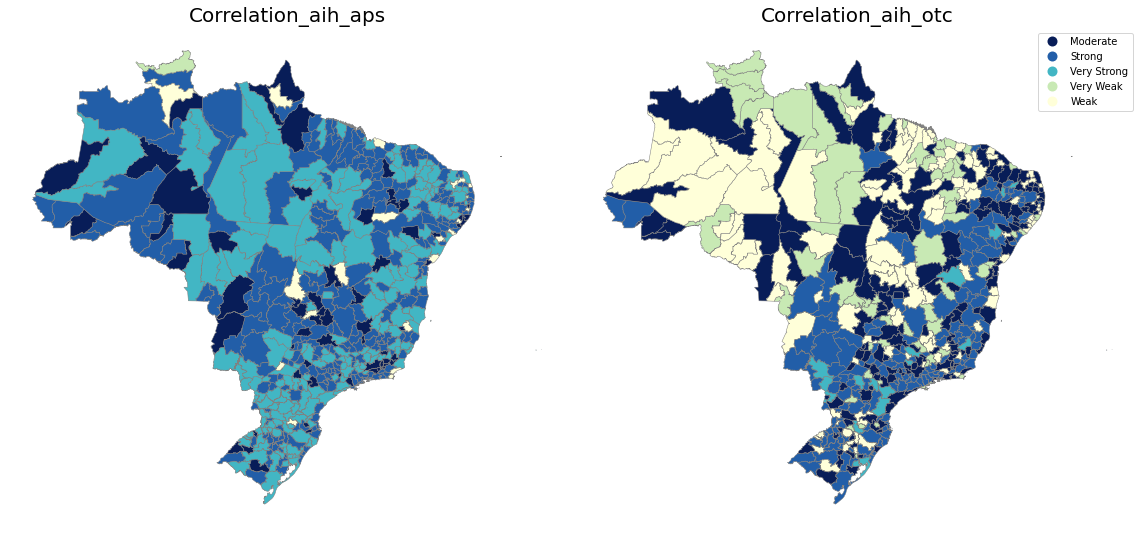

In [258]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first map - APS incidence with clipped color scale
#gdf.plot(column='Correlation_aps_otc_Class',
#         cmap='YlGnBu_r',
#         linewidth=0.5,
#         ax=ax[0],
#         edgecolor='gray',
#         legend=False,
         #vmax=43704.755618,
         #legend_kwds={'shrink': 0.5}  # Shrinks the colorbar (0.5 = half the default size)
#         )
         
        
#ax[0].set_title('Correlation_aps_otc', fontsize=20)
#ax[0].axis('off')

# Plot the second map - OTC incidence with clipped color scale
gdf.plot(column='Correlation_aih_aps_Class',
         cmap='YlGnBu_r',
         linewidth=0.5,
         ax=ax[0],
         edgecolor='gray',
         legend=False,
         #vmax=2.872972e+05,
         #legend_kwds={'shrink': 0.5}  # Shrinks the colorbar (0.5 = half the default size)
         )

ax[0].set_title('Correlation_aih_aps', fontsize=20)
ax[0].axis('off')

# Plot the second map - AIH incidence with clipped color scale
gdf.plot(column='Correlation_aih_otc_Class',
         cmap='YlGnBu_r',
         linewidth=0.5,
         ax=ax[1],
         edgecolor='gray',
         legend=True,
         #vmax = 1451.687889,
         #legend_kwds={'shrink': 0.5}  # Shrinks the colorbar (0.5 = half the default size)
         )

ax[1].set_title('Correlation_aih_otc', fontsize=20)
ax[1].axis('off')

# Adjust spacing
plt.tight_layout()

#plt.savefig('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/map_aih_otc_aps.png', dpi=300, bbox_inches='tight')
#plt.savefig('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/map_aih_otc_aps.pdf', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


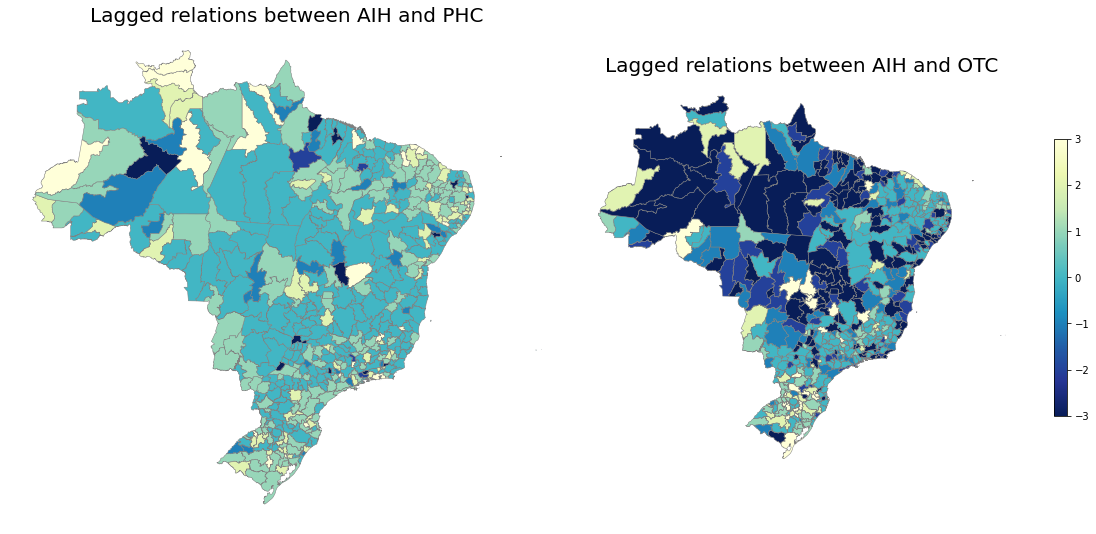

In [252]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first map - APS incidence with clipped color scale
#gdf.plot(column='Lag_APS_OTC',
#         cmap='YlGnBu_r',
#         linewidth=0.5,
#         ax=ax[0],
#         edgecolor='gray',
#         legend=False,
#         #vmax=43704.755618,
#         legend_kwds={'shrink': 0.5}  # Shrinks the colorbar (0.5 = half the default size)
#         )
         
        
#ax[0].set_title('A', fontsize=20)
#ax[0].axis('off')

# Plot the second map - OTC incidence with clipped color scale
gdf.plot(column='Lag_AIH_APS',
         cmap='YlGnBu_r',
         linewidth=0.5,
         ax=ax[0],
         edgecolor='gray',
         legend=False,
         #vmax=2.872972e+05,
         #legend_kwds={'shrink': 0.5}  # Shrinks the colorbar (0.5 = half the default size)
         )

ax[0].set_title('Lagged relations between AIH and PHC', fontsize=20)
ax[0].axis('off')

# Plot the second map - AIH incidence with clipped color scale
gdf.plot(column='Lag_AIH_OTC',
         cmap='YlGnBu_r',
         linewidth=0.5,
         ax=ax[1],
         edgecolor='gray',
         legend=True,
         #vmax = 1451.687889,
         legend_kwds={'shrink': 0.5}  # Shrinks the colorbar (0.5 = half the default size)
         )

ax[1].set_title('Lagged relations between AIH and OTC', fontsize=20)
ax[1].axis('off')

# Adjust spacing
plt.tight_layout()

#plt.savefig('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/map_aih_otc_aps.png', dpi=300, bbox_inches='tight')
#plt.savefig('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/map_aih_otc_aps.pdf', dpi=300, bbox_inches='tight')

# Show plot
plt.show()
